In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_art_merged = pd.read_csv('../data/cleaned_merged_all_articles.csv')
df = pd.read_csv("extracted_keywords.csv", index_col=0)
df["keyphrases"] = df["keyphrases"].apply(lambda x: [phrase[1:-1] for phrase in x[1:-1].split(", ")])
df["keyphrases"] = df["keyphrases"].apply(lambda x: [phrase for phrase in x if "congress" not in phrase])
df = df[df["year"] >= 2013]


keyphrase_data = []
for _, row in df.iterrows():
    for keyphrase in row['keyphrases']:
        keyphrase_data.append({'year': row['year'], 'month': row['month'], 'keyphrase': keyphrase})
keyphrase_df = pd.DataFrame(keyphrase_data)
keyphrase_df

,year,month,keyphrase
0,2024,8,israeli hostage rescue
1,2024,8,israeli arab hostage
2,2024,8,hamas captivity
3,2024,8,eighth hostage
4,2024,8,hostage home
...,...,...,...
335628,2024,8,national public data
335629,2024,8,briefing detail
335630,2024,8,privacy
335631,2024,8,notifying victim


In [3]:
keyphrase_df['time'] = pd.to_datetime(keyphrase_df[['year', 'month']].assign(day=1))
keyphrase_df['quarter'] = keyphrase_df['time'].dt.to_period('Q')

quarterly_counts = (
    keyphrase_df
    .groupby(['quarter', 'keyphrase'])
    .size()
    .reset_index(name='count')
)

In [10]:

top_per_year = (
    keyphrase_df
    .groupby(['year', 'keyphrase'])
    .size()
    .reset_index(name='count')
)

top_per_year = (
    top_per_year
    .groupby(['year'])
    .apply(lambda x: x.nlargest(1, 'count'))
    .reset_index(drop=True)
)
top_per_year

/tmp/ipykernel_17241/2242766669.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(1, 'count'))


,year,keyphrase,count
0,2013,affordable care act,46
1,2014,veteran,48
2,2015,epa,74
3,2016,veteran,44
4,2017,affordable care act,115
5,2018,trump administration,68
6,2019,bipartisan bill,74
7,2020,covid,103
8,2021,american rescue plan,126
9,2022,biden administration,121


In [5]:
df_art_merged['date'] = pd.to_datetime(df_art_merged['date'])
df_art_merged['year'] = df_art_merged['date'].dt.year
df_art_merged = df_art_merged[df_art_merged['year'] >= 2013]

In [6]:
df_art_merged['month'] = df_art_merged['date'].dt.month
df_art_merged['quarter'] = df_art_merged['date'].dt.to_period('Q')
articles_by_quarter = df_art_merged.groupby('quarter').size().reset_index(name='count')
vc = df_art_merged["quarter"].value_counts().sort_index()

In [7]:
def apply_to_all_axes(axes, func):
    for ax in axes:
        func(ax)
        
def plot_phrase(phrase, ax):
    data=quarterly_counts[quarterly_counts["keyphrase"] == phrase]
    ser = pd.Series(data['count'].values, index=data['quarter']).reindex(vc.index, fill_value=0)
    ser.plot(marker='o', markersize=4, linewidth=1.5, label=phrase, ax=ax)

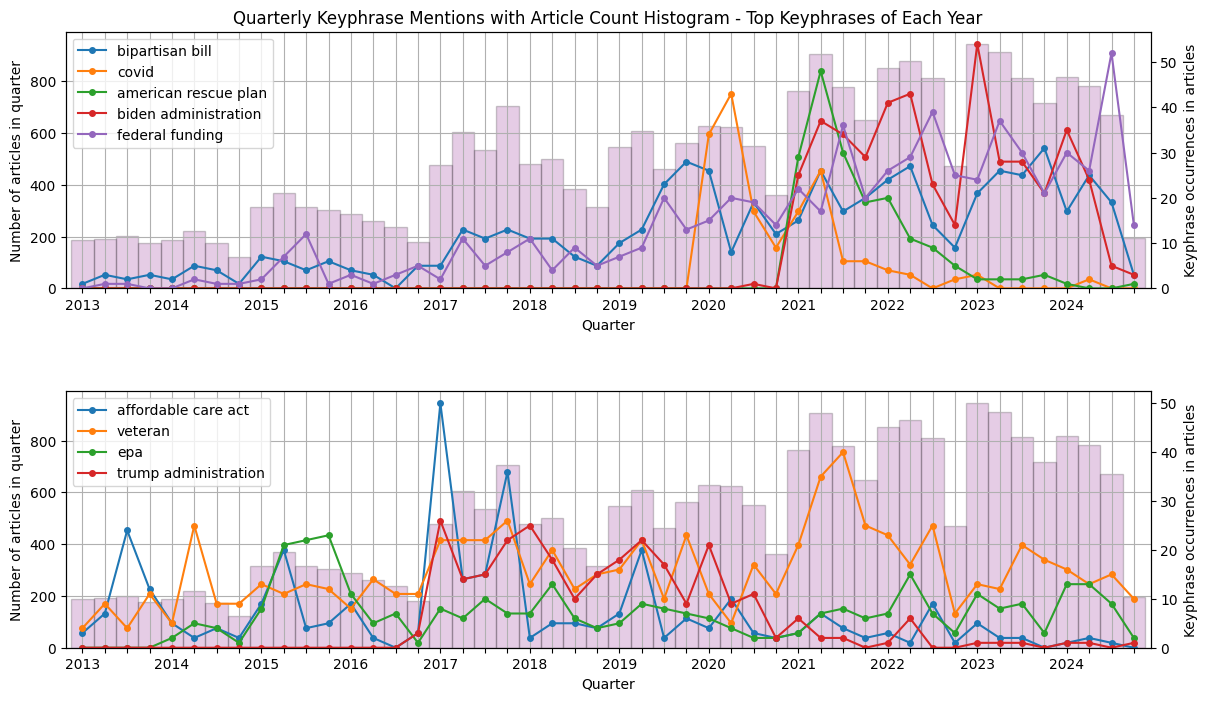

In [11]:
fig, axes = plt.subplots(figsize=(14, 8), nrows=2, ncols=1)
ax0_twin = axes[0].twinx()
ax1_twin = axes[1].twinx()

vc.plot(kind="bar", color="purple", alpha=0.2, width = 1, edgecolor="black", label="Number of Articles", ax = axes[0])
vc.plot(kind="bar", color="purple", alpha=0.2, width = 1, edgecolor="black", label="Number of Articles", ax = axes[1])

vc.index = vc.index.astype(str)


unique_keyphrases = top_per_year["keyphrase"].unique()
for i in range(len(unique_keyphrases)):
    ax = ax0_twin if i >= len(unique_keyphrases)//2 else ax1_twin
    plot_phrase(unique_keyphrases[i], ax)



apply_to_all_axes(axes, lambda ax: ax.set_xlabel('Quarter'))
apply_to_all_axes(axes, lambda ax: ax.set_ylabel('Number of articles in quarter'))
apply_to_all_axes([ax0_twin, ax1_twin], lambda ax: ax.set_ylabel('Keyphrase occurrences in articles'))
axes[0].set_title('Quarterly Keyphrase Mentions with Article Count Histogram - Top Keyphrases of Each Year')

ticks = [f'{2013+i//4}' if i % 4 == 0 else "" for i in range(0, len(vc))]
apply_to_all_axes(axes, lambda ax: ax.set_xticks(ticks=range(len(vc)), labels=ticks, rotation=0))

apply_to_all_axes(axes, lambda ax: ax.grid(True))

apply_to_all_axes([ax0_twin, ax1_twin], lambda ax: ax.set_ylim(0, ax.get_ylim()[1]))
apply_to_all_axes([ax0_twin, ax1_twin], lambda ax: ax.legend(loc='upper left'))

plt.subplots_adjust(hspace=0.4)
plt.savefig('./../charts/keyphrase_occurrences.png', bbox_inches='tight')

In [9]:
top_overall = (
    keyphrase_df
    .groupby(['keyphrase'])
    .size()
    .reset_index(name='count')
)
top_overall.sort_values(by='count', ascending=False).head(10)

,keyphrase,count
180065,veteran,747
62787,federal funding,660
15915,bill,622
17466,bipartisan bill,590
69775,funding,569
113582,national security,453
98717,legislation,447
15337,biden administration,445
143899,representative,408
18122,bipartisan legislation,403
